<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week13/SOM_countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to SOM

In [1]:
# Re-import necessary libraries after code execution state reset
!pip install minisom --quiet

  Preparing metadata (setup.py) ... done


Data shape: (27, 2)


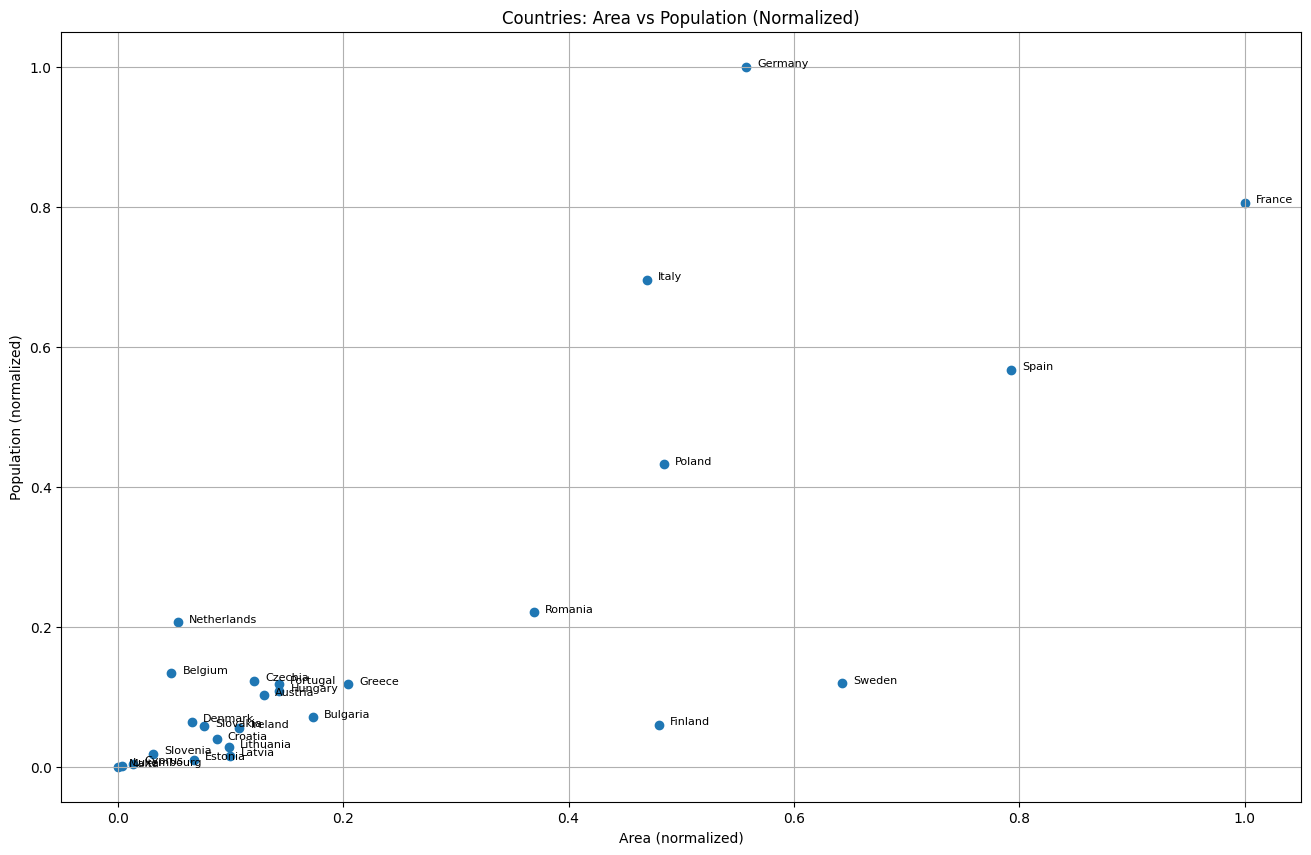

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Data: [Area, Population]
country_data = np.array([
    [82519, 9104772],
    [30452, 11754004],
    [110001, 6447710],
    [55896, 3850894],
    [9213, 920701],
    [77212, 10827529],
    [41987, 5932654],
    [43110, 1365884],
    [304316, 5563970],
    [633886, 68070697],
    [353296, 84358845],
    [130048, 10394055],
    [91248, 9597085],
    [68655, 5194336],
    [297825, 58850717],
    [63290, 1883008],
    [62643, 2857279],
    [2586, 660809],
    [313, 542051],
    [34188, 17811291],
    [307236, 36753736],
    [90996, 10467366],
    [234270, 19051562],
    [48702, 5428792],
    [20145, 2116792],
    [502654, 48059777],
    [407300, 10521556]
])

country_names = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
                 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
                 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
                 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']


print(f'Data shape: {country_data.shape}')

# Normalize the data (similar to mapminmax in MATLAB)
scaler = MinMaxScaler()
#scaler = StandardScaler()
data_scaled = scaler.fit_transform(country_data)

# --- Scatter plot of normalized data ---
plt.figure(figsize=(16,10))
plt.scatter(data_scaled[:,0], data_scaled[:,1])
for i, name in enumerate(country_names):
    plt.text(data_scaled[i,0]+0.01, data_scaled[i,1], name, fontsize=8)
plt.title("Countries: Area vs Population (Normalized)")
#plt.xscale('log')  # logarithmic scale (area)
#plt.yscale('log')  # logarithmic scale (population)
plt.xlabel("Area (normalized)")
plt.ylabel("Population (normalized)")
plt.grid(True)
plt.show()




In [11]:
from minisom import MiniSom
from collections import defaultdict
# Initialize and train SOM
som_shape = (6, 6)
som = MiniSom(x=som_shape[0], y=som_shape[1], input_len=2, sigma=1.0, learning_rate=0.5)
som.random_weights_init(data_scaled)
som.train_random(data_scaled, 1000)

# Create a dictionary to store which countries fall into each SOM neuron (BMU)
bmu_positions = defaultdict(list)
for i, x in enumerate(data_scaled):
    bmu = som.winner(x)  # Best Matching Unit for each country
    bmu_positions[bmu].append(country_names[i])  # Group countries by BMU position



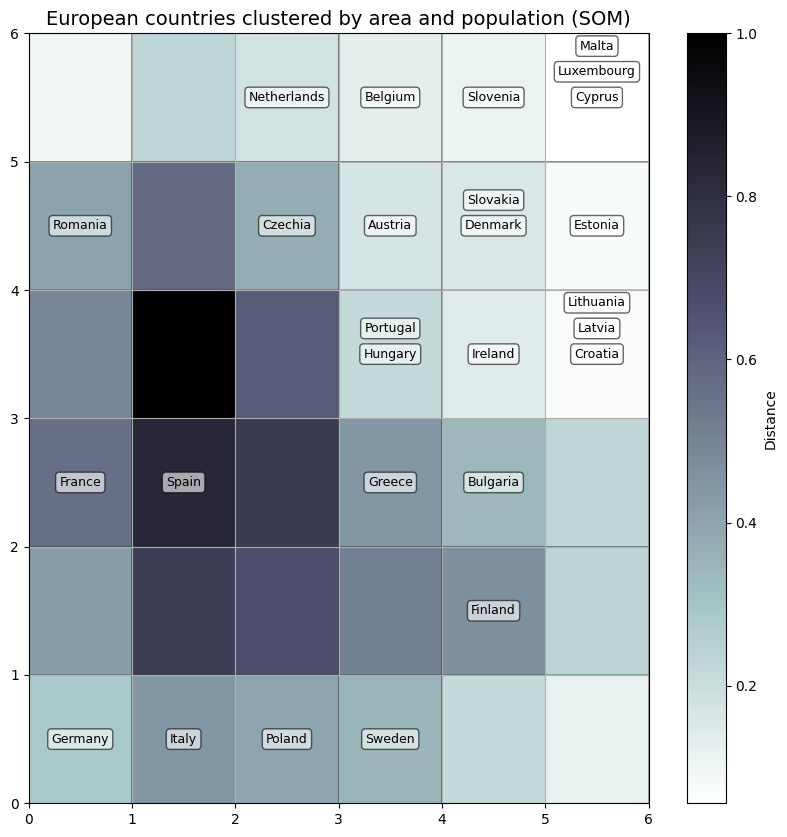

In [12]:
def plot_U_matrix(som, data_scaled, country_names):
    # Plot the U-matrix (Unified Distance Matrix
    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r', edgecolors='k')  # U-matrix as heatmap
    plt.colorbar(label='Distance')  # Color scale showing distance between neighboring neurons

    # Plot country names at their BMU positions, stacked vertically to avoid overlap
    for (x, y), names in bmu_positions.items():
        for i, name in enumerate(names):
            plt.text(x + 0.5, y + 0.5 + i * 0.2, name,  # vertical stacking
                    fontsize=9, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

    # Add title and grid
    plt.title('European countries clustered by area and population (SOM)', fontsize=14)
    plt.grid(True)
    plt.show()
# Plot the U-matrix (Unified Distance Matrix)
plot_U_matrix(som, data_scaled, country_names)

In [13]:
# Get winner coordinates for each country
bmu_coords = np.array([som.winner(x) for x in data_scaled])

# Convert coordinates to 1D cluster IDs
cluster_ids = [int(x * som_shape[1] + y) for x, y in bmu_coords]

# Group countries by cluster
from collections import defaultdict
clusters = defaultdict(list)
for i, cid in enumerate(cluster_ids):
    clusters[cid].append(country_names[i])

# Print grouped countries
for cid, countries in sorted(clusters.items()):
    print(f"Representant {cid}: {countries}")


Representant 0: ['Germany']
Representant 2: ['France']
Representant 4: ['Romania']
Representant 6: ['Italy']
Representant 8: ['Spain']
Representant 12: ['Poland']
Representant 16: ['Czechia']
Representant 17: ['Netherlands']
Representant 18: ['Sweden']
Representant 20: ['Greece']
Representant 21: ['Hungary', 'Portugal']
Representant 22: ['Austria']
Representant 23: ['Belgium']
Representant 25: ['Finland']
Representant 26: ['Bulgaria']
Representant 27: ['Ireland']
Representant 28: ['Denmark', 'Slovakia']
Representant 29: ['Slovenia']
Representant 33: ['Croatia', 'Latvia', 'Lithuania']
Representant 34: ['Estonia']
Representant 35: ['Cyprus', 'Luxembourg', 'Malta']


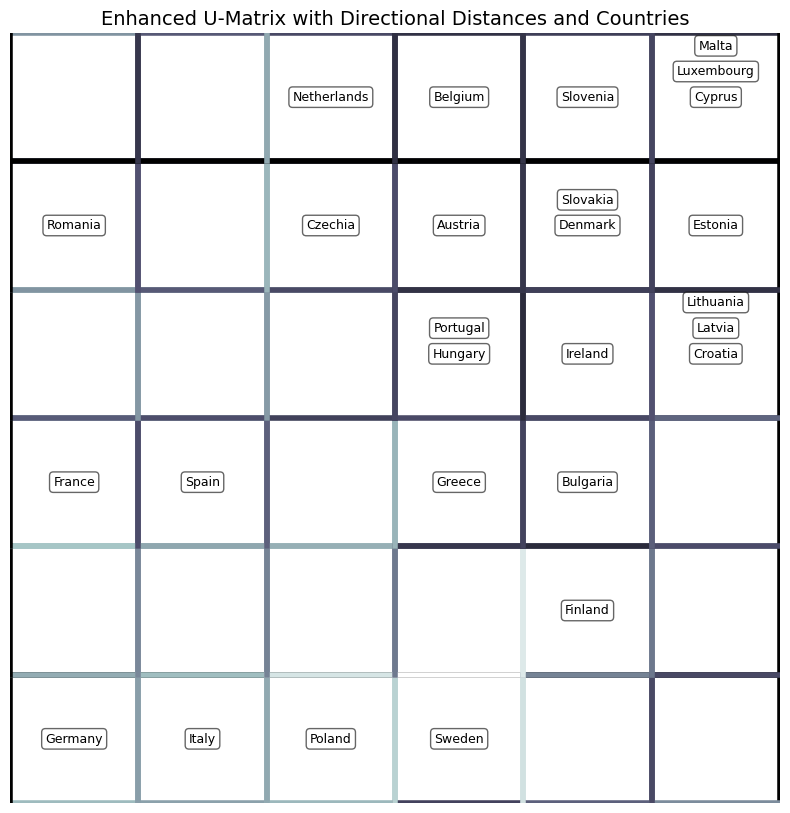

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
from collections import defaultdict
from numpy.linalg import norm

# Compute directional distances for each neuron: [top, right, bottom, left]
weights = som.get_weights()
umatrix = np.zeros((som_shape[0], som_shape[1], 4))  # shape: (rows, cols, 4 directions)
max_dist = 0

for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        w = weights[i, j]
        if i > 0:  # top
            d = norm(w - weights[i - 1, j])
            umatrix[i, j, 0] = d
            max_dist = max(max_dist, d)
        if j < som_shape[1] - 1:  # right
            d = norm(w - weights[i, j + 1])
            umatrix[i, j, 1] = d
            max_dist = max(max_dist, d)
        if i < som_shape[0] - 1:  # bottom
            d = norm(w - weights[i + 1, j])
            umatrix[i, j, 2] = d
            max_dist = max(max_dist, d)
        if j > 0:  # left
            d = norm(w - weights[i, j - 1])
            umatrix[i, j, 3] = d
            max_dist = max(max_dist, d)

# Group countries by their BMU positions
bmu_positions = defaultdict(list)
for i, x in enumerate(data_scaled):
    bmu = som.winner(x)
    bmu_positions[bmu].append(country_names[i])

# Plot the enhanced U-matrix
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        x, y = j, i  # Grid coordinates

        # Normalize directional distances
        #top, right, bottom, left = umatrix[i, j] / max_dist
        top = np.sqrt(umatrix[i, j, 0] / max_dist)
        right = np.sqrt(umatrix[i, j, 1] / max_dist)
        bottom = np.sqrt(umatrix[i, j, 2] / max_dist)
        left = np.sqrt(umatrix[i, j, 3] / max_dist)

        # Base square
        ax.add_patch(Rectangle((x, y), 1, 1, facecolor='white', edgecolor='gray'))

        # Directional edge colors (top, right, bottom, left)
        ax.plot([x, x + 1], [y + 1, y + 1], color=cm.bone(top), linewidth=4)     # top
        ax.plot([x + 1, x + 1], [y, y + 1], color=cm.bone(right), linewidth=4)   # right
        ax.plot([x, x + 1], [y, y], color=cm.bone(bottom), linewidth=4)          # bottom
        ax.plot([x, x], [y, y + 1], color=cm.bone(left), linewidth=4)            # left

# Plot country names stacked vertically
for (x, y), names in bmu_positions.items():
    for i, name in enumerate(names):
        ax.text(x + 0.5, y + 0.5 + i * 0.2, name,
                fontsize=9, ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

# Final layout settings
ax.set_xlim(0, som_shape[1])
ax.set_ylim(0, som_shape[0])
ax.set_ylim(som_shape[0], 0)
ax.set_aspect('equal')
plt.gca().invert_yaxis()  # Keep origin in top-left like in previous plots
plt.axis('off')
plt.title("Enhanced U-Matrix with Directional Distances and Countries", fontsize=14)
plt.show()


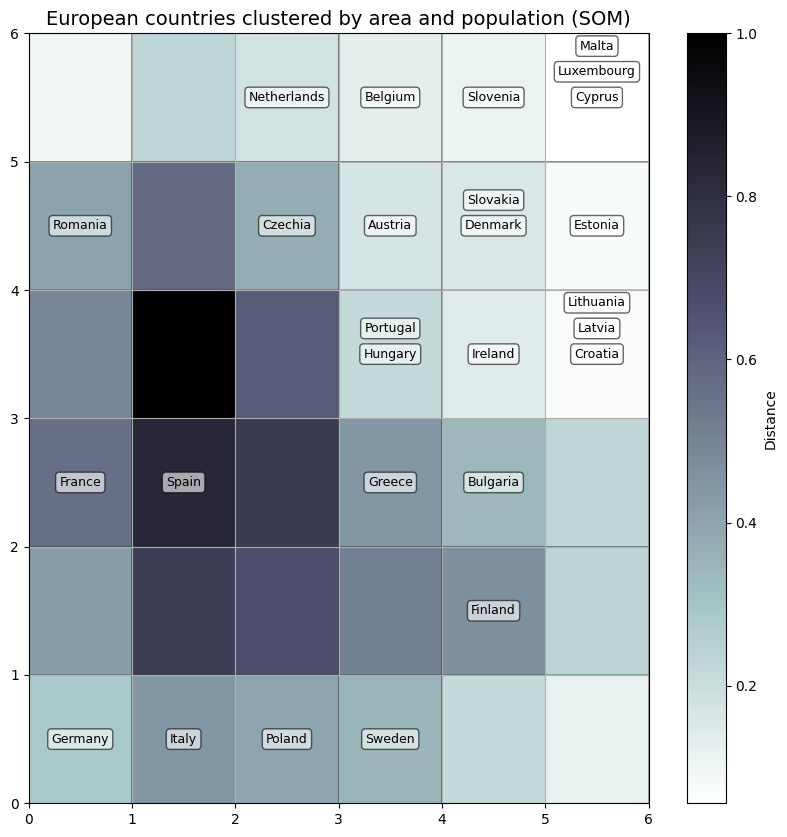

In [15]:
plot_U_matrix(som, data_scaled, country_names)

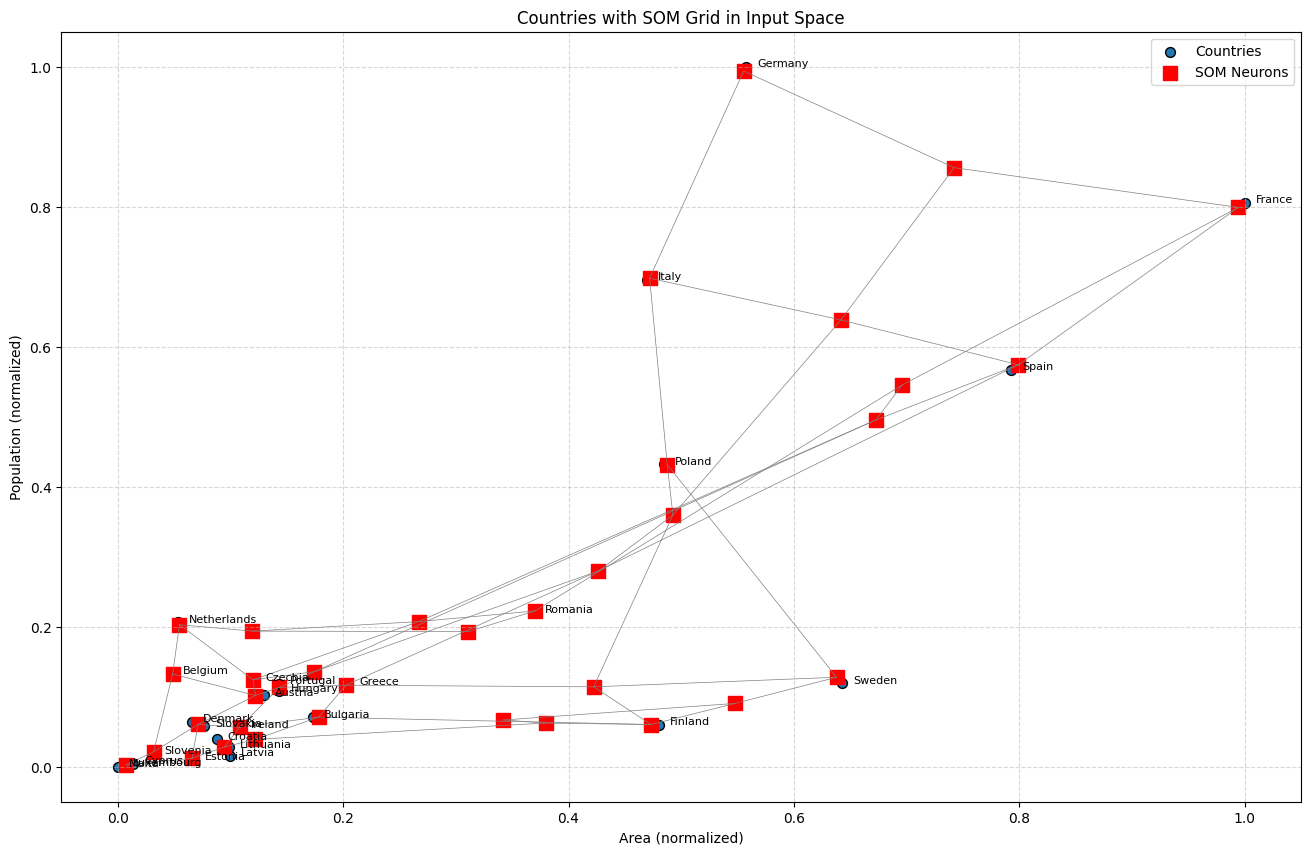

In [16]:
plt.figure(figsize=(16, 10))

# Plot data points
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], s=50, edgecolor='k', label='Countries')

# Add country names
for i, name in enumerate(country_names):
    plt.text(data_scaled[i, 0] + 0.01, data_scaled[i, 1], name, fontsize=8)

# Plot SOM neuron weights (i.e., grid in input space)
weights = som.get_weights().reshape(-1, data_scaled.shape[1])  # (num_neurons, 2)
plt.scatter(weights[:, 0], weights[:, 1], marker='s', s=100, c='red', label='SOM Neurons')

# Optionally: connect neurons in a grid (lines)
for i in range(som_shape[0]):
    for j in range(som_shape[1] - 1):
        w1 = som.get_weights()[i, j]
        w2 = som.get_weights()[i, j + 1]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)
for j in range(som_shape[1]):
    for i in range(som_shape[0] - 1):
        w1 = som.get_weights()[i, j]
        w2 = som.get_weights()[i + 1, j]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)

plt.title("Countries with SOM Grid in Input Space")
plt.xlabel("Area (normalized)")
plt.ylabel("Population (normalized)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


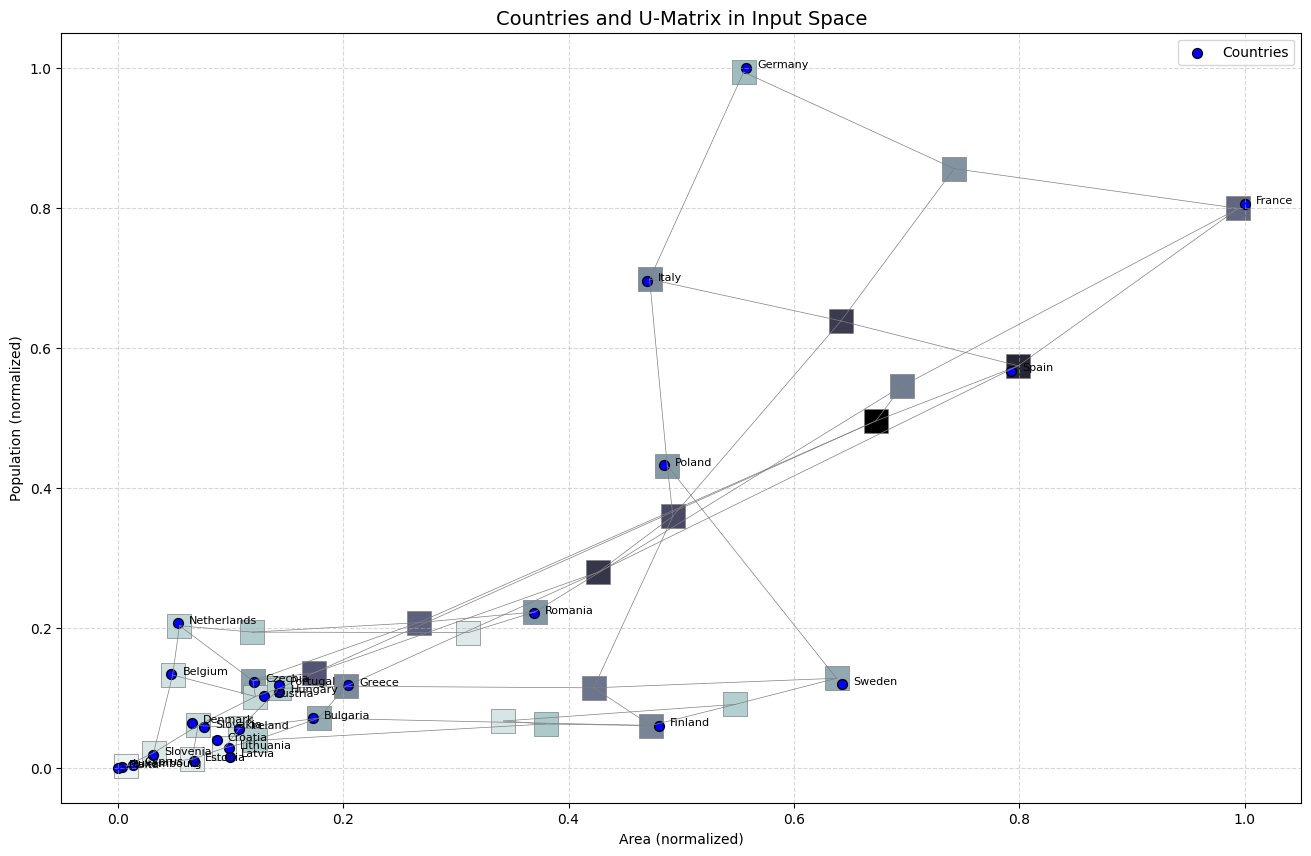

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Prepare U-matrix values as list of distances for each neuron
u_matrix = som.distance_map()

# Get weights and flatten them
weights = som.get_weights()
w_flat = weights.reshape(-1, weights.shape[2])  # shape (n_neurons, 2)

# Create figure
plt.figure(figsize=(16, 10))

# Plot U-matrix as background: place each neuron's U-value at its weight position
for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        w = weights[i, j]
        u = u_matrix[i, j]
        plt.scatter(w[0], w[1], color=cm.bone_r(u), s=300, marker='s', edgecolor='gray', linewidth=0.5)

# Connect neighboring neurons with gray lines (grid)
for i in range(som_shape[0]):
    for j in range(som_shape[1] - 1):
        w1 = weights[i, j]
        w2 = weights[i, j + 1]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)
for j in range(som_shape[1]):
    for i in range(som_shape[0] - 1):
        w1 = weights[i, j]
        w2 = weights[i + 1, j]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'gray', linewidth=0.5)

# Plot original data points (countries)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], s=50, edgecolor='black', facecolor='blue', label='Countries')
for i, name in enumerate(country_names):
    plt.text(data_scaled[i, 0] + 0.01, data_scaled[i, 1], name, fontsize=8)

# Final touches
plt.title("Countries and U-Matrix in Input Space", fontsize=14)
plt.xlabel("Area (normalized)")
plt.ylabel("Population (normalized)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
